In [1]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, cmap="gray", label=None, **kwargs):
    fig, ax = plt.subplots(figsize=(3, 3))
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [2]:
# Start by creating an image model
import cryojax.simulator as cxs
from cryojax.io import read_array_from_mrc


# Scattering potential stored in MRC format
filename = "./data/groel_5w0s_scattering_potential.mrc"
# ... read into a FourierVoxelGridPotential
real_voxel_grid, voxel_size = read_array_from_mrc(filename, loads_grid_spacing=True)
potential = cxs.FourierVoxelGridVolume.from_real_voxel_grid(
    real_voxel_grid, pad_scale=2
)
# Now, instantiate the pose. Angles are given in degrees
pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=5.0,
    offset_y_in_angstroms=-3.0,
    phi_angle=20.0,
    theta_angle=80.0,
    psi_angle=-5.0,
)
# First, the contrast transfer theory
ctf = cxs.AstigmaticCTF(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
)
transfer_theory = cxs.ContrastTransferTheory(ctf, amplitude_contrast_ratio=0.1)
# Then the configuration. Add padding with respect to the final image shape.
pad_options = dict(shape=potential.shape[0:2])
config = cxs.BasicImageConfig(
    shape=(80, 80),
    pixel_size=voxel_size,
    voltage_in_kilovolts=300.0,
    pad_options=pad_options,
)
# Make the image model. By default, cryoJAX will simulate
# the contrast in physical units. Rather, normalize the image.
image_model = cxs.make_image_model(
    potential,
    config,
    pose,
    transfer_theory,
    normalizes_signal=True,
)

In [15]:
from functools import wraps
from inspect import signature

import equinox as eqx
import jax
import jax.numpy as jnp
import torch
from jax import dlpack as jax_dlpack
from torch.utils import dlpack as torch_dlpack


def j2t(x_jax, requires_grad=False):
    """Convert `jax.Array` to `torch.Tensor`."""
    if requires_grad:
        # ... cannot use dlpack if `requires_grad = True` 
        x_torch = torch.tensor(jax.device_get(x_jax), requires_grad=True)
    else:
        x_torch = torch_dlpack.from_dlpack(x_jax)
    assert x_torch.shape == x_jax.shape, f"{x_torch.shape}, {x_jax.shape}"
    return x_torch

def t2j(x_torch):
    """Convert `torch.Tensor` to `jax.Array`."""
    x_torch = x_torch.contiguous() # https://github.com/google/jax/issues/8082
    if x_torch.requires_grad:
        # ... cannot use dlpack if `requires_grad = True` 
        x_jax = jnp.asarray(x_torch.numpy())
    else:
        x_jax = jax_dlpack.from_dlpack(x_torch)
    assert x_torch.shape == x_jax.shape
    return x_jax

def tree_t2j(x_torch):
    return jax.tree.map(lambda t: t2j(t) if isinstance(t, torch.Tensor) else t, x_torch)

def tree_j2t(x_jax, requires_grad=False):
    return jax.tree.map(lambda t: j2t(t, requires_grad) if isinstance(t, jax.Array) else t, x_jax)

def jax2torch(fn):
    @wraps(fn)
    def inner(*args, **kwargs):
        class JaxFun(torch.autograd.Function):
            @staticmethod
            def forward(ctx, *args):
                args = tree_t2j(args)
                y_, ctx.fun_vjp = eqx.filter_vjp(fn, *args)
                return tree_j2t(y_)

            @staticmethod
            def backward(ctx, *grad_args):
                grad_args = tree_t2j(grad_args) if len(grad_args) > 1 else t2j(grad_args[0])
                grads = ctx.fun_vjp(grad_args)
                grads = tuple(map(lambda t: t if isinstance(t, jnp.ndarray) else None, grads))
                return tree_j2t(grads)

        sig = signature(fn)
        bound = sig.bind(*args, **kwargs)
        bound.apply_defaults()
        return JaxFun.apply(*bound.arguments.values())
    return inner

In [16]:
import equinox as eqx

# JIT compiled image simulation
@eqx.filter_jit
def simulate_fn(image_model):
    return image_model.simulate()

# Convert image model to torch with `tree_j2t`
torch_image_model = tree_j2t(image_model)
# Convert JIT compiled function in JAX to torch
torch_simulate_fn = jax2torch(simulate_fn)

(<Figure size 300x300 with 2 Axes>, <Axes: >)

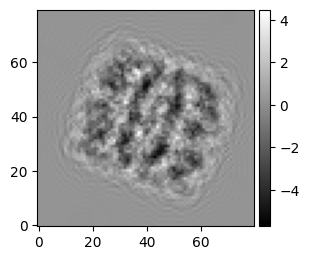

In [17]:
# Simulate image using torch
image = torch_simulate_fn(torch_image_model)
assert isinstance(image, torch.Tensor)
plot_image(image)

In [28]:
import equinox as eqx
import jax.numpy as jnp
from cryojax.jax_util import make_filter_spec


observed_image = simulate_fn(image_model)
where_pose = lambda x: x.pose
filter_spec = make_filter_spec(image_model, where_pose)
model_grad, model_nograd = eqx.partition(image_model, filter_spec)

@eqx.filter_jit
def loss_fn(model_grad, model_nograd, observed_image):
    image_model = eqx.combine(model_grad, model_nograd)
    return jnp.sum((simulate_fn(image_model) - observed_image) ** 2)

torch_model_grad, observed_image = tree_j2t((model_grad, observed_image), requires_grad=True)
torch_model_nograd = tree_j2t(model_nograd)
torch_loss_fn = jax2torch(loss_fn)
loss_value = torch_loss_fn(torch_model_grad, torch_model_nograd, observed_image)
print(loss_value)

tensor(2.1277e-09, grad_fn=<JaxFunBackward>)


In [30]:
loss_value.backward()
grad_pose = jax.tree.map(lambda x: x.grad, where_pose(torch_model_grad))
print(grad_pose)

EulerAnglePose(
  offset_x_in_angstroms=None,
  offset_y_in_angstroms=None,
  offset_z_in_angstroms=None,
  phi_angle=None,
  theta_angle=None,
  psi_angle=None
)


In [36]:
where_pose(torch_model_grad).phi_angle.grad